In [1]:
# We will now implement a multi layer perceptron
# We're going to do a character-level language model, instead of a word-level language model

# They maximize log likelihood w/ training data
# And it then transfers knowledge in embeddings

In [ ]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
%matplotlib inline

In [5]:
words = open('data/names.txt', 'r').read().splitlines()
words[:8]

['emma', 'olivia', 'ava', 'isabella', 'sophia', 'charlotte', 'mia', 'amelia']

In [7]:
len(words)

32033

In [8]:
chars = sorted(list(set(''.join(words))))
stoi = {s:i+1 for i,s in enumerate(chars)}
stoi['.'] = 0
itos = {i:s for s,i in stoi.items()}
print(itos)

{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}


In [11]:
# Build dataset
block_size = 3 # context length: how many characters do we take to predict the next char?
X, Y = [], []

for w in words[:5]:
  print(w)
  context = [0] * block_size
  for ch in w + '.':
    ix = stoi[ch]
    X.append(context)
    Y.append(ix)
    print(''.join(itos[i] for i in context), '--->', itos[ix])
    context = context[1:] + [ix]

X = torch.tensor(X)
Y = torch.tensor(Y)

emma
... ---> e
..e ---> m
.em ---> m
emm ---> a
mma ---> .
olivia
... ---> o
..o ---> l
.ol ---> i
oli ---> v
liv ---> i
ivi ---> a
via ---> .
ava
... ---> a
..a ---> v
.av ---> a
ava ---> .
isabella
... ---> i
..i ---> s
.is ---> a
isa ---> b
sab ---> e
abe ---> l
bel ---> l
ell ---> a
lla ---> .
sophia
... ---> s
..s ---> o
.so ---> p
sop ---> h
oph ---> i
phi ---> a
hia ---> .


In [13]:
X.shape, X.dtype, Y.shape, Y.dtype

(torch.Size([32, 3]), torch.int64, torch.Size([32]), torch.int64)

In [14]:
X

tensor([[ 0,  0,  0],
        [ 0,  0,  5],
        [ 0,  5, 13],
        [ 5, 13, 13],
        [13, 13,  1],
        [ 0,  0,  0],
        [ 0,  0, 15],
        [ 0, 15, 12],
        [15, 12,  9],
        [12,  9, 22],
        [ 9, 22,  9],
        [22,  9,  1],
        [ 0,  0,  0],
        [ 0,  0,  1],
        [ 0,  1, 22],
        [ 1, 22,  1],
        [ 0,  0,  0],
        [ 0,  0,  9],
        [ 0,  9, 19],
        [ 9, 19,  1],
        [19,  1,  2],
        [ 1,  2,  5],
        [ 2,  5, 12],
        [ 5, 12, 12],
        [12, 12,  1],
        [ 0,  0,  0],
        [ 0,  0, 19],
        [ 0, 19, 15],
        [19, 15, 16],
        [15, 16,  8],
        [16,  8,  9],
        [ 8,  9,  1]])

In [108]:
Y

tensor([ 5, 13, 13,  1,  0, 15, 12,  9, 22,  9,  1,  0,  1, 22,  1,  0,  9, 19,
         1,  2,  5, 12, 12,  1,  0, 19, 15, 16,  8,  9,  1,  0])

In [17]:
# In the paper, they do 17,000 words -> 30 dimension
# We will do 27 characters -> 2 dimensions
C = torch.randn((27, 2))

In [21]:
# So to get the embedding, let's say for the 5th character, we do
F.one_hot(torch.tensor(5), num_classes=27).float() @ C

# Same as
C[5]

tensor([0.4646, 1.3848])

In [26]:
# Torch indexing is very flexible!
C[torch.tensor([5,6,7, 7, 7])]

tensor([[ 0.4646,  1.3848],
        [-0.0652, -0.7418],
        [-0.4296,  0.9141],
        [-0.4296,  0.9141],
        [-0.4296,  0.9141]])

In [28]:
# Can even do this - where we get the C of every element in X
# Which gives us the embeddings for the inputs!
emb = C[X]
emb.shape

torch.Size([32, 3, 2])

In [30]:
# The # of inputs is 3 * 2 since we have 3 2-dimensional embeddings
# And we have 100 neurons
W1 = torch.randn((6, 100))

# Random biases
b1 = torch.randn(100)

In [49]:
print(emb)

tensor([[[-1.2689,  1.7355],
         [-1.2689,  1.7355],
         [-1.2689,  1.7355]],

        [[-1.2689,  1.7355],
         [-1.2689,  1.7355],
         [ 0.4646,  1.3848]],

        [[-1.2689,  1.7355],
         [ 0.4646,  1.3848],
         [ 2.0428, -0.5955]],

        [[ 0.4646,  1.3848],
         [ 2.0428, -0.5955],
         [ 2.0428, -0.5955]],

        [[ 2.0428, -0.5955],
         [ 2.0428, -0.5955],
         [-0.6615,  0.3514]],

        [[-1.2689,  1.7355],
         [-1.2689,  1.7355],
         [-1.2689,  1.7355]],

        [[-1.2689,  1.7355],
         [-1.2689,  1.7355],
         [ 0.9882,  0.3476]],

        [[-1.2689,  1.7355],
         [ 0.9882,  0.3476],
         [ 1.9198,  0.3074]],

        [[ 0.9882,  0.3476],
         [ 1.9198,  0.3074],
         [ 1.7650,  1.3553]],

        [[ 1.9198,  0.3074],
         [ 1.7650,  1.3553],
         [-0.0022, -1.6173]],

        [[ 1.7650,  1.3553],
         [-0.0022, -1.6173],
         [ 1.7650,  1.3553]],

        [[-0.0022, -1

In [37]:
# Below doesn't work! Embeddings shape needs to be modified
# emb @ W1 + b1
# Need to convert the [32, 3, 2] into a [32, 6]
# We can use torch.cat()!
print(emb[:, 0, :].shape)
print(emb[:, 0, :])

torch.Size([32, 2])
tensor([[-1.2689,  1.7355],
        [-1.2689,  1.7355],
        [-1.2689,  1.7355],
        [ 0.4646,  1.3848],
        [ 2.0428, -0.5955],
        [-1.2689,  1.7355],
        [-1.2689,  1.7355],
        [-1.2689,  1.7355],
        [ 0.9882,  0.3476],
        [ 1.9198,  0.3074],
        [ 1.7650,  1.3553],
        [-0.0022, -1.6173],
        [-1.2689,  1.7355],
        [-1.2689,  1.7355],
        [-1.2689,  1.7355],
        [-0.6615,  0.3514],
        [-1.2689,  1.7355],
        [-1.2689,  1.7355],
        [-1.2689,  1.7355],
        [ 1.7650,  1.3553],
        [ 0.1875, -0.2631],
        [-0.6615,  0.3514],
        [ 0.9252,  0.0763],
        [ 0.4646,  1.3848],
        [ 1.9198,  0.3074],
        [-1.2689,  1.7355],
        [-1.2689,  1.7355],
        [-1.2689,  1.7355],
        [ 0.1875, -0.2631],
        [ 0.9882,  0.3476],
        [-0.1134,  0.6159],
        [ 0.4853,  0.5186]])


In [33]:
torch.cat([emb[:, 0, :],  emb[:, 1, :], emb[:, 2, :]], 1)

tensor([[-1.2689,  1.7355, -1.2689,  1.7355, -1.2689,  1.7355],
        [-1.2689,  1.7355, -1.2689,  1.7355,  0.4646,  1.3848],
        [-1.2689,  1.7355,  0.4646,  1.3848,  2.0428, -0.5955],
        [ 0.4646,  1.3848,  2.0428, -0.5955,  2.0428, -0.5955],
        [ 2.0428, -0.5955,  2.0428, -0.5955, -0.6615,  0.3514],
        [-1.2689,  1.7355, -1.2689,  1.7355, -1.2689,  1.7355],
        [-1.2689,  1.7355, -1.2689,  1.7355,  0.9882,  0.3476],
        [-1.2689,  1.7355,  0.9882,  0.3476,  1.9198,  0.3074],
        [ 0.9882,  0.3476,  1.9198,  0.3074,  1.7650,  1.3553],
        [ 1.9198,  0.3074,  1.7650,  1.3553, -0.0022, -1.6173],
        [ 1.7650,  1.3553, -0.0022, -1.6173,  1.7650,  1.3553],
        [-0.0022, -1.6173,  1.7650,  1.3553, -0.6615,  0.3514],
        [-1.2689,  1.7355, -1.2689,  1.7355, -1.2689,  1.7355],
        [-1.2689,  1.7355, -1.2689,  1.7355, -0.6615,  0.3514],
        [-1.2689,  1.7355, -0.6615,  0.3514, -0.0022, -1.6173],
        [-0.6615,  0.3514, -0.0022, -1.6

In [ ]:
# This returns a tuple for word 1, 2, and 3!
torch.unbind(emb, 1)
# So then we can do
# On the first dimension (adding columns)
torch.cat(torch.unbind(emb, 1), 1)

tensor([[-1.2689,  1.7355, -1.2689,  1.7355, -1.2689,  1.7355],
        [-1.2689,  1.7355, -1.2689,  1.7355,  0.4646,  1.3848],
        [-1.2689,  1.7355,  0.4646,  1.3848,  2.0428, -0.5955],
        [ 0.4646,  1.3848,  2.0428, -0.5955,  2.0428, -0.5955],
        [ 2.0428, -0.5955,  2.0428, -0.5955, -0.6615,  0.3514],
        [-1.2689,  1.7355, -1.2689,  1.7355, -1.2689,  1.7355],
        [-1.2689,  1.7355, -1.2689,  1.7355,  0.9882,  0.3476],
        [-1.2689,  1.7355,  0.9882,  0.3476,  1.9198,  0.3074],
        [ 0.9882,  0.3476,  1.9198,  0.3074,  1.7650,  1.3553],
        [ 1.9198,  0.3074,  1.7650,  1.3553, -0.0022, -1.6173],
        [ 1.7650,  1.3553, -0.0022, -1.6173,  1.7650,  1.3553],
        [-0.0022, -1.6173,  1.7650,  1.3553, -0.6615,  0.3514],
        [-1.2689,  1.7355, -1.2689,  1.7355, -1.2689,  1.7355],
        [-1.2689,  1.7355, -1.2689,  1.7355, -0.6615,  0.3514],
        [-1.2689,  1.7355, -0.6615,  0.3514, -0.0022, -1.6173],
        [-0.6615,  0.3514, -0.0022, -1.6

In [53]:
a = torch.arange(18)
a

tensor([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17])

In [55]:
a.shape

torch.Size([18])

In [ ]:
# We can show the numbers however we want, as long as the numbers input to view all multiply to 18!
# View is incredibly efficient! No memory is being modified, except for offsets
a.view(3, 3, 2)

tensor([[[ 0,  1],
         [ 2,  3],
         [ 4,  5]],

        [[ 6,  7],
         [ 8,  9],
         [10, 11]],

        [[12, 13],
         [14, 15],
         [16, 17]]])

In [ ]:
# So we can actually just do
# torch.cat uses new memory, view does not!
emb.view(32, 6) == torch.cat(torch.unbind(emb, 1), 1)

tensor([[True, True, True, True, True, True],
        [True, True, True, True, True, True],
        [True, True, True, True, True, True],
        [True, True, True, True, True, True],
        [True, True, True, True, True, True],
        [True, True, True, True, True, True],
        [True, True, True, True, True, True],
        [True, True, True, True, True, True],
        [True, True, True, True, True, True],
        [True, True, True, True, True, True],
        [True, True, True, True, True, True],
        [True, True, True, True, True, True],
        [True, True, True, True, True, True],
        [True, True, True, True, True, True],
        [True, True, True, True, True, True],
        [True, True, True, True, True, True],
        [True, True, True, True, True, True],
        [True, True, True, True, True, True],
        [True, True, True, True, True, True],
        [True, True, True, True, True, True],
        [True, True, True, True, True, True],
        [True, True, True, True, T

In [61]:
# So now, we can just do
h = torch.tanh((emb.view(32, 6) @ W1) + b1)
# can also do
# h = emb.view(emb.shape[0], 6)
# or (pytorch infers here)
# h = emb.view(-1, 6)

h

tensor([[ 0.6699, -0.9992,  0.4297,  ...,  0.9999,  0.3012, -0.9983],
        [ 0.9941, -0.9856, -0.7988,  ...,  0.9960, -0.5465, -0.9999],
        [ 1.0000,  0.8604, -0.8324,  ..., -0.8411, -0.8631, -1.0000],
        ...,
        [ 0.9943,  0.8192, -0.8191,  ...,  0.6251, -0.0999, -0.8317],
        [ 0.9653, -0.9826, -0.5978,  ...,  0.9500,  0.4354, -1.0000],
        [ 0.9913, -0.8080,  0.9172,  ...,  0.9973,  0.3097, -0.7281]])

In [62]:
# Verifying broadcast for b
b1.shape
# 100

# 32, 100
# 100

# 32, 100
#  1, 100

# So b gets converted into a row, and then copied 32 times!
# This ends up working, because in emb @ W1, the row number stands for the individual x input, and the column stands for the neuron activation

torch.Size([100])

In [63]:
W2 = torch.randn((100, 27))
b2 = torch.randn(27)

In [64]:
logits = h @ W2 + b2
logits.shape

torch.Size([32, 27])

In [83]:
counts = logits.exp()
prob = counts / counts.sum(1, keepdims=True)
prob.sum(dim=1)

tensor([1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000])

In [84]:
# We then utilize probs to measure the loss compared to Y
# This takes each row, and for each row, indexes the Y
prob[torch.arange(32), Y]

tensor([6.6239e-06, 3.4231e-10, 1.4917e-02, 9.7041e-10, 3.3887e-10, 2.3657e-14,
        9.1010e-10, 1.2283e-06, 1.9128e-05, 4.8293e-08, 4.8924e-04, 6.3088e-18,
        4.6204e-03, 4.5562e-11, 2.3545e-02, 2.3537e-13, 9.5793e-07, 5.0070e-05,
        6.3385e-06, 3.6557e-03, 2.1117e-04, 3.8939e-13, 6.4696e-06, 1.9937e-10,
        1.0685e-08, 1.1385e-08, 8.3143e-12, 7.3225e-08, 5.3958e-10, 1.5396e-03,
        9.9267e-01, 2.2592e-15])

In [86]:
avg_nll = -prob[torch.arange(32), Y].log().mean()

In [87]:
# Redone
g = torch.Generator().manual_seed(2147483647)
C = torch.randn((27, 2), generator=g)
W1 = torch.randn((6, 100), generator=g)
b1 = torch.randn(100, generator=g)
W2 = torch.randn((100, 27), generator=g)
b2 = torch.randn(27, generator=g)

parameters = [C, W1, b1, W2, b2]

In [88]:
sum(p.nelement() for p in parameters)

3481

In [103]:
emb = C[X] # (32, 2, 2)
h = torch.tanh(emb.view(-1, 6) @ W1 + b1)
logits = h @ W2 + b2
# counts = logits.exp()
# probs = counts / counts.sum(1, keepdims=True)
# loss = -prob[torch.arange(32), Y].log().mean()
loss = F.cross_entropy(logits, Y)
loss

tensor(17.7697)

In [94]:
# Calculates the loss
# Is also much more efficient too - can take advantage of mathematical efficencies as well as kernel optimizations
F.cross_entropy(logits, Y)
loss

tensor(16.7512)

In [158]:
# Anther reason is to use cross_entropy is because of this
# -100 is okay, cause e^-100 is just a small number
# but 100 is bad as it blows up to a very large number (inf)
logits = torch.tensor([-100, -3, 0, 100])
# logits is now inf, and it blows up our probs!
counts = logits.exp()
probs = counts / counts.sum()
probs

# Mathematical property
logits = torch.tensor([-100, -3, 0, 100])
# If you offset the above by a constant, it doens't affect the result!
# So pytorch first offsets by minusing the largest constant number and then doing the e

logits

tensor([-100,   -3,    0,  100])

In [319]:
# Build dataset
block_size = 3 # context length: how many characters do we take to predict the next char?
X, Y = [], []

for w in words:
  # print(w)
  context = [0] * block_size
  for ch in w + '.':
    ix = stoi[ch]
    X.append(context)
    Y.append(ix)
    # print(''.join(itos[i] for i in context), '--->', itos[ix])
    context = context[1:] + [ix]

X = torch.tensor(X)
Y = torch.tensor(Y)

In [330]:
# Redone again
g = torch.Generator().manual_seed(2147483647)
C = torch.randn((27, 10), generator=g)
W1 = torch.randn((30, 200), generator=g)
b1 = torch.randn(200, generator=g)
W2 = torch.randn((200, 27), generator=g)
b2 = torch.randn(27, generator=g)

parameters = [C, W1, b1, W2, b2]

In [331]:
sum(p.nelement() for p in parameters)

11897

In [332]:
for p in parameters:
  p.requires_grad = True

In [333]:
def build_dataset(words):
  block_size = 3
  X, Y = [], []
  for w in words:
    context = [0] * block_size
    for ch in w + '.':
      ix = stoi[ch]
      X.append(context)
      Y.append(ix)
      context = context[1:] + [ix]

  X = torch.tensor(X)
  Y = torch.tensor(Y)
  print(X.shape, Y.shape)
  return X, Y

import random
random.seed(42)
random.shuffle(words)
n1 = int(.8 * len(words))
n2 = int(.9 * len(words))

Xtr, Ytr = build_dataset(words[:n1])
Xdev, Ydev = build_dataset(words[n1:n2])
Xte, Yte = build_dataset(words[n2:])

torch.Size([182484, 3]) torch.Size([182484])
torch.Size([22869, 3]) torch.Size([22869])
torch.Size([22793, 3]) torch.Size([22793])


In [342]:
# lri = []
lossi = []
stepi = []

In [344]:
lre = torch.linspace(-3, 0, 1000)
lrs = 10 ** lre

for i in range(50000):
  # Batching
  indexes = torch.randint(0, Xtr.shape[0], (32,))
  # Using training set
  batch_X = Xtr[indexes]
  batch_Y = Ytr[indexes]

  emb = C[batch_X] # (32, 3, 2)
  reshaped_emb = emb.view(-1, 30) # (32, )
  h = torch.tanh(reshaped_emb @ W1 + b1) # (32, 100)
  logits = h @ W2 + b2 # (32, 27)

  avg_nll = F.cross_entropy(logits, batch_Y)
  # print(avg_nll)

  for p in parameters:
    p.grad = None

  avg_nll.backward()

  # lr = -lrs[i]
  lr = -.01
  for p in parameters:
    p.data += lr * p.grad
  
  # lri.append(lre[i])
  lossi.append(avg_nll.item())
  stepi.append(i)

In [336]:
def infer(X):
  emb = C[X] # (1, 3, 2)
  reshaped_emb = emb.view(-1, 30) # (1, 6)
  h = torch.tanh(reshaped_emb @ W1 + b1) # (1, 100)
  logits = h @ W2 + b2 # (1, 27)
  exp_logits = torch.squeeze(logits).exp()
  p = exp_logits / exp_logits.sum()

  ix = torch.multinomial(p, num_samples=1, replacement=True).item()
  return ix

infer_arr = [0, 0, 0]
name = []

while True:
  ix = infer(infer_arr)
  print(ix)
  
  if ix == 0:
    break

  infer_arr.append(ix)
  infer_arr.pop(0)

  print(infer_arr)

  name.append(itos[ix])

print("".join(name))

4
[0, 0, 4]
9
[0, 4, 9]
4
[4, 9, 4]
25
[9, 4, 25]
12
[4, 25, 12]
9
[25, 12, 9]
1
[12, 9, 1]
14
[9, 1, 14]
0
didylian


In [210]:
# With 32 examples, we overfit hard! Got really close to 0. But all the generations are just the names we put in examples!
# The loss never hits exaclty 0, as with ..., the next char can be a, e, i, o - essentially it's branching - so there is no way to be perfect there

In [ ]:
# With the whole dataset, training takes wayyy to long - cause with each iteration to calculate the loss, we're infering with the whole dataset!
# So we wanna instead uses batches of Y to calculate the loss instead!

# Batch of 32
torch.randint(0, X.shape[0], (32,))

# Since we're using mini batches, quality of gradient is lower and approximate, but we can do way more steps due to the smaller size!


tensor([[ 0,  0,  0],
        [ 0,  0,  5],
        [ 0,  5, 13],
        ...,
        [26, 26, 25],
        [26, 25, 26],
        [25, 26, 24]])

In [297]:
# Evaluating full loss (on dev) after training
h = torch.tanh(C[Xdev].view(-1, 6) @ W1 + b1)
logits = h @ W2 + b2
loss = F.cross_entropy(logits, Ydev)
loss

# The loss kinda stagnates at around 2

tensor(2.3555, grad_fn=<NllLossBackward0>)

In [ ]:
# How do we optimize learning rates?
# Manual observation first - look for a leraning rate that is too slow (.001)
# Find a learning rate that is way to high (10). We'll use 1 here.
# THen create a linear space -
torch.linspace(.001, 1, 1000)
# We can use this to step through our learning rate! But linear doen'st really make sense here
lre = torch.linspace(-3, 0, 1000)
lrs = 10 ** lre
lrs

# We then utilize these learning rates in the training loop, and track the loss stats as we do so

tensor([0.0010, 0.0010, 0.0010, 0.0010, 0.0010, 0.0010, 0.0010, 0.0010, 0.0011,
        0.0011, 0.0011, 0.0011, 0.0011, 0.0011, 0.0011, 0.0011, 0.0011, 0.0011,
        0.0011, 0.0011, 0.0011, 0.0012, 0.0012, 0.0012, 0.0012, 0.0012, 0.0012,
        0.0012, 0.0012, 0.0012, 0.0012, 0.0012, 0.0012, 0.0013, 0.0013, 0.0013,
        0.0013, 0.0013, 0.0013, 0.0013, 0.0013, 0.0013, 0.0013, 0.0013, 0.0014,
        0.0014, 0.0014, 0.0014, 0.0014, 0.0014, 0.0014, 0.0014, 0.0014, 0.0014,
        0.0015, 0.0015, 0.0015, 0.0015, 0.0015, 0.0015, 0.0015, 0.0015, 0.0015,
        0.0015, 0.0016, 0.0016, 0.0016, 0.0016, 0.0016, 0.0016, 0.0016, 0.0016,
        0.0016, 0.0017, 0.0017, 0.0017, 0.0017, 0.0017, 0.0017, 0.0017, 0.0017,
        0.0018, 0.0018, 0.0018, 0.0018, 0.0018, 0.0018, 0.0018, 0.0018, 0.0019,
        0.0019, 0.0019, 0.0019, 0.0019, 0.0019, 0.0019, 0.0019, 0.0020, 0.0020,
        0.0020, 0.0020, 0.0020, 0.0020, 0.0020, 0.0021, 0.0021, 0.0021, 0.0021,
        0.0021, 0.0021, 0.0021, 0.0022, 

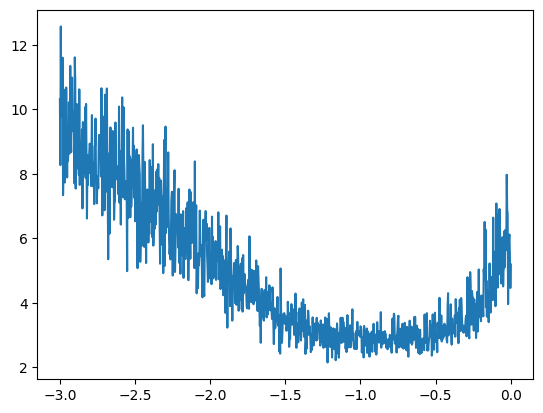

In [247]:
# Then we plot the learning rates vs loss!
plt.plot(lri, lossi)

In [262]:
# You then want to find the valley - -1.0 is a good learning rate by this experiment in the above image
# or -.1

In [265]:
# So we're able to achieve a loss of 2.3! Better than the bigram model!
# But we can't just say that, since our model might be overfitting the data. (Low test loss, high validation loss!)
# So we need to make a training, dev/validation, and test split!
# Should only validate on test set very few times!
# Typically 80%, 10%, 10%

# So now we modify the inputs to reflect this!

In [ ]:
# You'll notice that loss on dev is pretty similar to the loss on training
# If the training loss is equal to test loss, it means your underfitting 
# Let's now scale up the size of the network!

torch.Size([182437, 3]) torch.Size([182437])
torch.Size([22781, 3]) torch.Size([22781])
torch.Size([22928, 3]) torch.Size([22928])


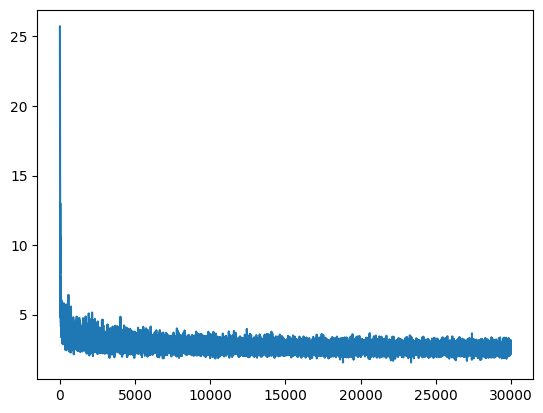

In [302]:
# Plot after increasing parameters to 300
plt.plot(stepi, lossi)

In [313]:
# Evaluating full loss (on dev) after training for 300 nodes
h = torch.tanh(C[Xtr].view(-1, 6) @ W1 + b1)
logits = h @ W2 + b2
loss = F.cross_entropy(logits, Ytr)
loss

# The loss kinda stagnates at around 2

tensor(2.2886, grad_fn=<NllLossBackward0>)

In [314]:
# Evaluating full loss (on dev) after training for 300 nodes
h = torch.tanh(C[Xdev].view(-1, 6) @ W1 + b1)
logits = h @ W2 + b2
loss = F.cross_entropy(logits, Ydev)
loss

# The loss kinda stagnates at around 2

tensor(2.3105, grad_fn=<NllLossBackward0>)

In [ ]:
# 300 nodes isn't helping too much - they both stagnate around 2.3 again.
# This might be because the embedding vectors are too small! (Just 2)

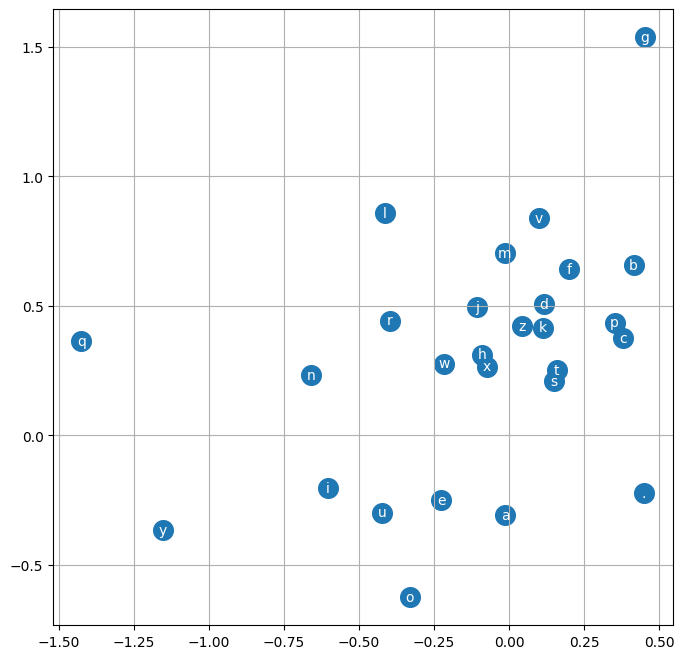

In [317]:
# Visualization of the current embedings (with 2)
plt.figure(figsize=(8,8))
plt.scatter(C[:,0].data, C[:,1].data, s=200)
for i in range(C.shape[0]):
  plt.text(C[i,0].item(), C[i,1].item(), itos[i], ha="center", va="center", color="white")
plt.grid('minor')

# Interesting observations - the model has grouped all the vowels together!

In [318]:
# Now let's do 10 dimensional embeddings!

In [ ]:
# Finally, you ahve all the hyperparamters
# Numbers of words you feed in at a time, the embedding space for a character, batch size, lr, etc

In [345]:
# Evaluating full loss (on tr) after training
h = torch.tanh(C[Xtr].view(-1, 30) @ W1 + b1)
logits = h @ W2 + b2
loss = F.cross_entropy(logits, Ytr)
loss

# The loss kinda stagnates at around 2

tensor(2.1416, grad_fn=<NllLossBackward0>)

In [346]:
# Evaluating full loss (on dev) after training for 300 nodes
h = torch.tanh(C[Xdev].view(-1, 30) @ W1 + b1)
logits = h @ W2 + b2
loss = F.cross_entropy(logits, Ydev)
loss

# The loss kinda stagnates at around 2

tensor(2.1784, grad_fn=<NllLossBackward0>)

In [ ]:
# The we're actually learning a lot more here! The slight difference (.03) between tr and dev shows a little bit of overfitting
# It seems that a higher dimension embedding space is what we needed!